In [1]:
import torch
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision.transforms import ToTensor

from s3dg import S3D

s3d_model = S3D('s3d_dict.npy', 512)
s3d_model.load_state_dict(torch.load('s3d_howto100m.pth'))

s3d_model = s3d_model.eval()
s3d_model = s3d_model.to('cuda')

In [2]:
video_dir = Path("/flybyml/module/s3d/alignment_sample")
text = [filepath.split(".mp4")[0].replace("_", " ") for filepath in os.listdir(video_dir)]

def video_to_tensor(video_path):
    print(str(video_path))

    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print("not opened")

    frames = []
    toTensor = ToTensor()
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (256, 256), interpolation=cv2.INTER_AREA)
        frame = toTensor(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        frame = torch.tensor(frame, dtype=torch.float32) / 255.0
        frames.append(frame)
    if len(frames) % 2 == 1:
        frames = frames[:-1]
        
    cap.release()

    return torch.stack(frames).permute(1, 0, 2, 3).unsqueeze(0)

def compute_v2t_similarity_matrix(video, text):
    with torch.no_grad():
        text_output = s3d_model.text_module([text])["text_embedding"]
        text_emb = text_output[0]
        video_emb = s3d_model(video)["video_embedding"]
    return torch.matmul(text_emb, video_emb.t()).item()


/flybyml/module/s3d/alignment_sample/leveling_off_from_banking_left.mp4


/tmp/ipykernel_92161/181999708.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frame = torch.tensor(frame, dtype=torch.float32) / 255.0


torch.Size([1, 3, 216, 256, 256])
/flybyml/module/s3d/alignment_sample/pitching_up.mp4
torch.Size([1, 3, 234, 256, 256])
/flybyml/module/s3d/alignment_sample/level_flight.mp4
torch.Size([1, 3, 366, 256, 256])
/flybyml/module/s3d/alignment_sample/banking_left.mp4
torch.Size([1, 3, 256, 256, 256])
/flybyml/module/s3d/alignment_sample/pitching_down.mp4
torch.Size([1, 3, 258, 256, 256])
/flybyml/module/s3d/alignment_sample/leveling_off_from_banking_right.mp4
torch.Size([1, 3, 238, 256, 256])
/flybyml/module/s3d/alignment_sample/banking_right.mp4
torch.Size([1, 3, 244, 256, 256])


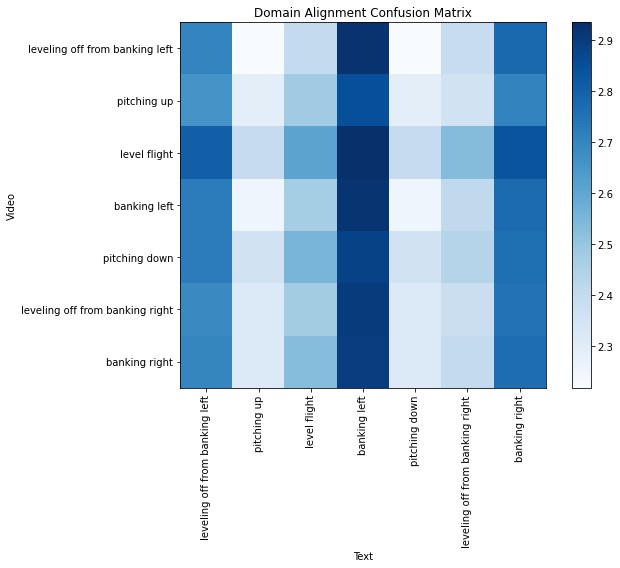

In [3]:
sim = []

for file_path in os.listdir(video_dir):
    vt = video_to_tensor(video_dir / file_path)
    vt = vt.to('cuda')
    print(vt.shape)
    for t in text:
        sim.append(compute_v2t_similarity_matrix(vt, t))

sim_matrix = np.array(sim).reshape(len(text), len(text))
plt.figure(figsize=(10, 8))
plt.imshow(sim_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Domain Alignment Confusion Matrix')
plt.xlabel('Text')
plt.ylabel('Video')
plt.xticks(np.arange(len(text)), text, rotation=90)
plt.yticks(np.arange(len(text)), text)
plt.tight_layout()
plt.show()

/flybyml/module/s3d/alignment_sample/leveling_off_from_banking_left.mp4


/tmp/ipykernel_92161/181999708.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frame = torch.tensor(frame, dtype=torch.float32) / 255.0


/flybyml/module/s3d/alignment_sample/pitching_up.mp4
/flybyml/module/s3d/alignment_sample/level_flight.mp4
/flybyml/module/s3d/alignment_sample/banking_left.mp4
/flybyml/module/s3d/alignment_sample/pitching_down.mp4
/flybyml/module/s3d/alignment_sample/leveling_off_from_banking_right.mp4
/flybyml/module/s3d/alignment_sample/banking_right.mp4


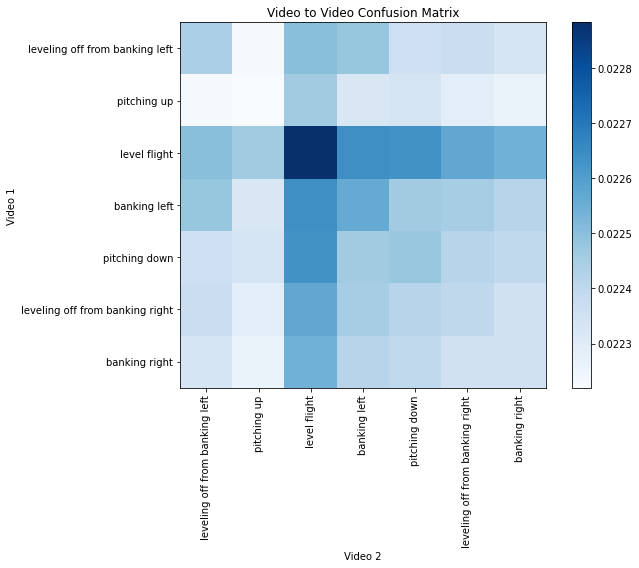

In [4]:
sim = []
vts = []

for fp in os.listdir(video_dir):
    vt = video_to_tensor(video_dir / fp)
    vt = vt.to('cuda')
    with torch.no_grad():
        vt_emb = s3d_model(vt)["video_embedding"]
    vts.append(vt_emb)

for v1 in vts:
    for v2 in vts:
        sim.append(torch.matmul(v1, v2.t()).item())

sim_matrix = np.array(sim).reshape(len(text), len(text))
plt.figure(figsize=(10, 8))
plt.imshow(sim_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Video to Video Confusion Matrix')
plt.xlabel('Video 2')
plt.ylabel('Video 1')
plt.xticks(np.arange(len(text)), text, rotation=90)
plt.yticks(np.arange(len(text)), text)
plt.tight_layout()
plt.show()

In [ ]:
import os

demodir = "C:/Users/lee/Desktop/ml/flybyml/module/s3d/demonstration" 
demo_embeddings = []
for i, path in enumerate(os.listdir(demodir)):
    demopath = os.path.join(demodir, f"level_off_4s_{i+1}.mp4")
    demo = video_to_tensor(demopath)
    demo_embeddings.append(s3d_model(demo)['video_embedding'])

failpath = "C:/Users/lee/Desktop/ml/flybyml/module/s3d/failure/level_off_4s.mp4"
failure_embedding = s3d_model(video_to_tensor(failpath))['video_embedding']

In [ ]:
text = ['cockpit leveling out the plane']
text_embedding = s3d_model.text_module(text)['text_embedding']

# compute all the pairwise similarity scores between video and text
for i, t in enumerate(text):
    print(f'"{t}" simularity with level-off demo')
    for j in range(3):
        similarity_matrix = torch.matmul(text_embedding[i], demo_embeddings[j].t())
        print(similarity_matrix.item())
    print("-----------")

In [ ]:
for i, t in enumerate(text):
    print(f'"{t}" simularity with level-off failure video')
    similarity_matrix = torch.matmul(text_embedding[i], failure_embedding.t())
    print(similarity_matrix.item())
    print("-----------")


In [ ]:
btw_demo = torch.matmul(demo_embeddings[0], demo_embeddings[1].t())
print(btw_demo.item())

In [ ]:
with_failure = torch.matmul(demo_embeddings[0], failure_embedding.t())
print(with_failure.item())